In [30]:
from IPython import display

# Distributed Quantum Image and Signal Encoding for Multi-class Classification

<b>Team: Qualition</b>

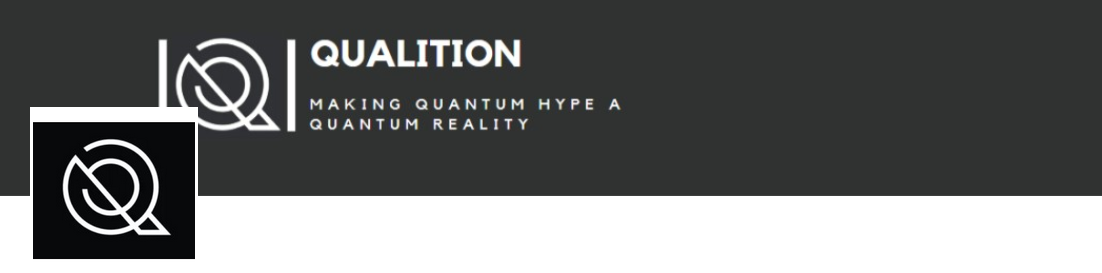

In [31]:
display.Image(r'Qualition.png')

<b>Members: Bultrini, Daniel - Conte, Pablo - Ortega, Neil John - Nezhad, Amirali Malekani</b>

In the code below, we will implement a distributed amplitude encoder for encoding images in chunks of size <b>n</b>, which yields a bigger image of size <b>N</b>. The number of chunks is determined by <b>N/n</b>, and the number of qubits per chunk is determined by $ceil(log2(n))$. This approach is useful given it allows us to encode high dimensional data using shallow <b>Parameterized Quantum Circuits (PQCs)</b>, maintaining a high fidelity (78 %). This approach can be further improved by shallower <b>PQC's</b> which perform amplitude encoding using a lower depth, whilst maintaining the fidelity, which allows us to encode larger chunks for better fidelity. Furthermore, we can load multiple chunks in parallel to have a faster encoding process for the overall image.

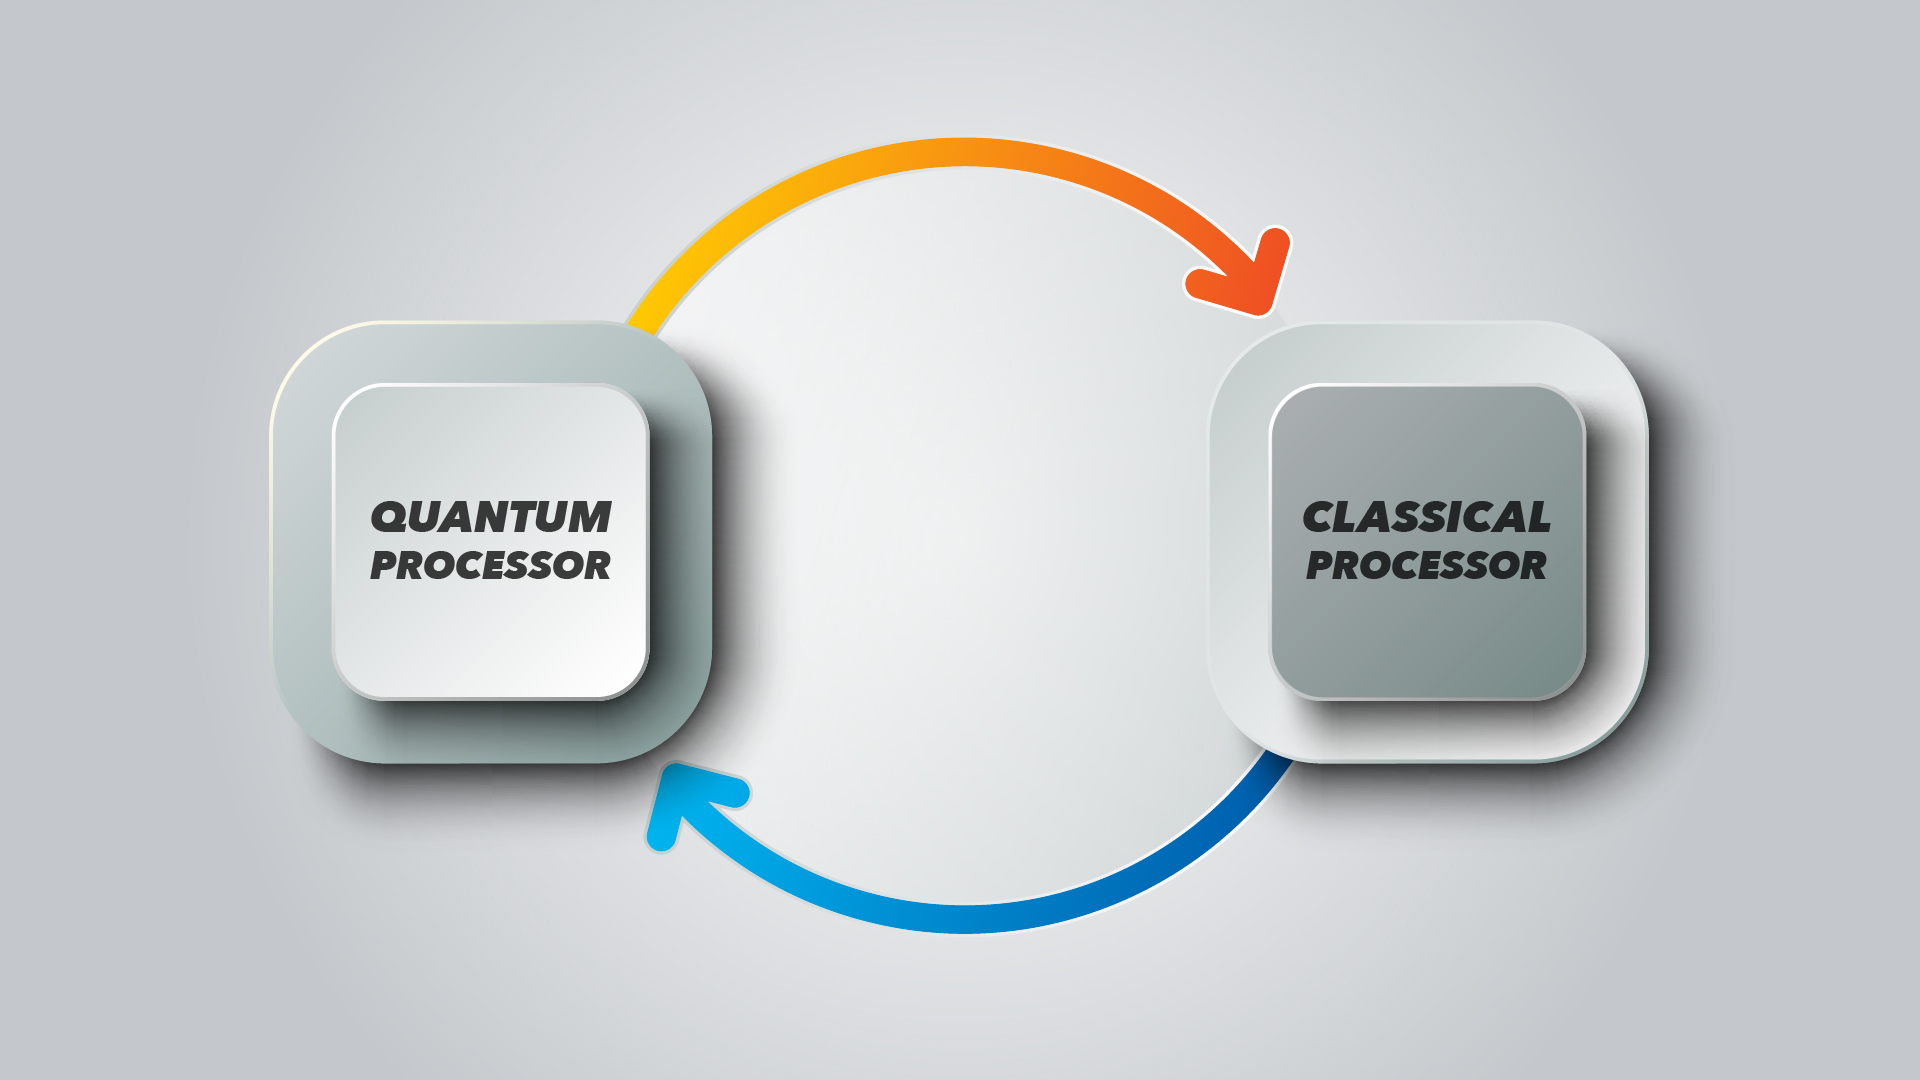

In [32]:
display.Image(r'ONISQ.jpg')


After, we will implement a Variational Quantum Classifier and a Quantum Convolutional Neural Network to perform the classification. 

The pipeline for the overall process is :

1) Import dataset

2) Pass image to encoder

    2.1) Split image to smaller chunks and normalize each chunk

    2.2) Encode each chunk using RawFeatureVector (RFV) PQC

    2.3) Simulate each chunk to extract the statevector

    2.4) Append all chunks classically together and renormalize

    2.5) Denormalize the image statevector(Optional: decode to see the image)

3) Pass statevector to classifer

4) Train classifier

5) Evaluate on test dataset

### Installed Required Libraries

In [33]:
#pip install tensorflow

In [34]:
#pip install sklearn

In [35]:
#pip install matplotlib

In [36]:
#pip install qiskit

First, we will import the necessary packages. For the model, we will be using Qiskit, for plotting we will be using Matplotlib, and for the dataset we will be importing TensorFlow's Fashion MNIST dataset.

In [37]:
# Linear Algebra
import numpy as np

# Type Hinting
from typing import Dict, List

# Plotting
from matplotlib import pyplot as plt
import pickle

# Collections
from collections import Counter

#Qiskit Tools
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, BasicAer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
from qiskit.providers.aer import QasmSimulator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator


#TensorFlow
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

print("All packages imported successfully!")

All packages imported successfully!


We will load the train and test datapoints.

In [38]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

We get the shape of the datapoints

In [39]:
data_shape = X_train[0].shape

To see how many qubits we will need for the overall image, we will take the $log2$ of the image vector. This is essentially to see how many qubits we need to cover all pixels.

In [40]:
print(f'Number of qubits needed: {int(np.ceil(np.log2(X_train[0].size)))}')

Number of qubits needed: 10


In some cases, the number of qubits for the datapoint can support even higher number of pixels. For instance, Fashion MNIST uses $28 x 28$ images, which means each image has $784$ pixels. We will need $10$ qubits at least to represent the image, but we can represent a maximum of $1024$ pixels. However, even if we don't wish to add any additional pixels, we still need to pad the vector with zero's to get a vector of $1024$.

In [41]:
print(f'Number of pixels covered with 10 qubits: {2**int(np.ceil(np.log2(X_train[0].size)))}')


Number of pixels covered with 10 qubits: 1024


Here is our normalize and denormalize function.

In [42]:
def normalize(x):
    """It takes in a vector as an input, and returns the 2-norm normalized vector.

    Args:
        x (np.array): 
            The image vector.

    Returns:
        (numpy.array): The 2-norm normalized vector.
    """
    x = x.flatten() # First we flatten the image in case it is a 2d array
    normalized_vector = x / np.linalg.norm(x) # Then we normalize the vector to 2-norm
    normalized_vector = [*normalized_vector] # We then format to return an np.array

    return normalized_vector # we return the normalized vector

def de_normalize(normalized_vector, x):
    """It takes in a 2-norm normalized vector as an input, and returns denormalized vector.

    Args:
        x (np.array): 
            The 2-norm normalized vector.

    Returns:
        (numpy.array): The denormalized vector.
    """
    return normalized_vector * np.linalg.norm(x.flatten()) # We return the denormalized vector by applying the inverse of the normalization factor

We can see how these functions work in the cell below.

In [43]:
normalized_vector = np.array(normalize(X_train[0]))
de_normalized_vector = de_normalize(normalized_vector,np.array(X_train[0]))

In [44]:
np.allclose(
        X_train[0], np.reshape(np.array(de_normalized_vector[:784]),data_shape), rtol=1e-4
    )

True

We create and append all the normalized vectors of 100 images of the training set.

In [45]:
X_train_list = []
for i in range(100):
    X_train_list.append(normalize(X_train[i]))

np.shape(X_train_list)

(100, 784)

We create and append all the normalized vectors of the test set.

In [46]:
X_test_list = []
for i in range(100):
    X_test_list.append(normalize(X_test[i]))
np.shape(X_test_list)

(100, 784)

To encode an image, we follow the steps below :

1) Pass image to encoder

2) Split image to smaller chunks and normalize each chunk

3) Encode each chunk using RawFeatureVector (RFV) PQC

4) Simulate each chunk to extract the statevector

5) Append all chunks classically together and renormalize

6) Denormalize the image statevector (Optional : decode to see the image)

Here is an image before normalizing.

Before Normalizing:


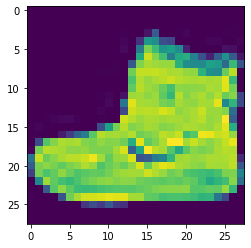

In [47]:
print('Before Normalizing:')
plt.imshow(X_train[0])
plt.show()

Now, we have the same image after normalizing. We can see the image is not changed, hence assuring us the ratios are the same.

After Normalize:


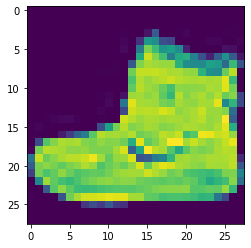

In [48]:
normalized_vector = normalize(X_train[0])
print('After Normalize:')
plt.imshow(np.reshape(np.array(normalized_vector[:784]),data_shape))
plt.show()

The $PQC$ we will be using to encode the image chunks will be <b>RawFeatureVector</b>. This is a shallow $PQC$ used for real-valued amplitude encoding. For a vector of size <b>n</b>, we will need a minimum of $ceil(log2(n))$ qubits, and must pad the vector to make sure it matches 2<sup>(ceil(log2(n))</sup> = $n$. 

In [67]:
state = normalized_vector
n = 10
qc = RawFeatureVector(2**n)
print("This circuit has " + str(n) + " qubits and " + str(qc.num_parameters) + " parameters.")
print("Circuit Graph")
qc.bind_parameters(np.random.uniform(0, 1023, 1024)).decompose(reps=20).draw()

This circuit has 10 qubits and 1024 parameters.
Circuit Graph


┌───────────────┐                                                    »
q_0: ─|0>─┤ U(1.6093,0,0) ├────────────────────────────────────────────────────»
          ├───────────────┤                                                    »
q_1: ─|0>─┤ U(1.4845,0,0) ├────────────────────────────────────────────────────»
          ├───────────────┤                                                    »
q_2: ─|0>─┤ U(1.5365,0,0) ├────────────────────────────────────────────────────»
          ├───────────────┤                                                    »
q_3: ─|0>─┤ U(1.5755,0,0) ├────────────────────────────────────────────────────»
          ├───────────────┤                                                    »
q_4: ─|0>─┤ U(1.5877,0,0) ├────────────────────────────────────────────────────»
          ├───────────────┤                                                    »
q_5: ─|0>─┤ U(1.5649,0,0) ├────────────────────────────────────────────────────»
          └┬──────────────┤                                                    »
q_6: ─|0>──┤ U(1.577,0,0) ├────────────────────────────────────────────────────»
          ┌┴──────────────┤                             ┌───┐┌────────────────┐»
q_7: ─|0>─┤ U(1.5748,0,0) ├─────────────────────────────┤ X ├┤ U(-0.0419,0,0) ├»
          ├───────────────┤┌───┐┌─────────────────┐┌───┐└─┬─┘└────────────────┘»
q_8: ─|0>─┤ U(1.5934,0,0) ├┤ X ├┤ U(0.040819,0,0) ├┤ X ├──■────────────────────»
          ├───────────────┤└─┬─┘└─────────────────┘└─┬─┘                       »
q_9: ─|0>─┤ U(1.5868,0,0) ├──■───────────────────────■─────────────────────────»
          └───────────────┘                                                    »
«                                                                »
«q_0: ───────────────────────────────────────────────────────────»
«                                                                »
«q_1: ───────────────────────────────────────────────────────────»
«                                                                »
«q_2: ───────────────────────────────────────────────────────────»
«                                                                »
«q_3: ───────────────────────────────────────────────────────────»
«                                                                »
«q_4: ───────────────────────────────────────────────────────────»
«                                                                »
«q_5: ───────────────────────────────────────────────────────────»
«                                                           ┌───┐»
«q_6: ──────────────────────────────────────────────────────┤ X ├»
«     ┌───┐┌──────────────────┐┌───┐┌─────────────────┐┌───┐└─┬─┘»
«q_7: ┤ X ├┤ U(-0.035784,0,0) ├┤ X ├┤ U(0.034911,0,0) ├┤ X ├──■──»
«     └─┬─┘└──────────────────┘└─┬─┘└─────────────────┘└─┬─┘     »
«q_8: ──┼────────────────────────■───────────────────────┼───────»
«       │                                                │       »
«q_9: ──■────────────────────────────────────────────────■───────»
«                                                                »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_1: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_2: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_3: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_4: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_5: ─────

The $simulate(circ)$ function takes a circuit, and extracts the statevector. We can use either the StatevectorSimulator or design a protocol that extracts this from measurements. 

Using the cell below, we can choose the best parameters for our simulator with respect to precision and GPU.

In [50]:
backend = StatevectorSimulator(precision='single')
backend.available_devices()

('CPU',)

In [51]:
def simulate(circ: qiskit.QuantumCircuit) -> dict:
    """This is the simulate(circ) function, which takes a circuit, and extracts the statevector.

    Args:
        circ (qiskit.QuantumCircuit): 
            The quantum circuit representing the encoded vector.

    Returns:
        (dict): The simulated statevector as a dict.
    """
    backend = StatevectorSimulator(precision='double', device = "CPU", max_parallel_threads = 12) # First we initialize our backend
    job = execute(circ, backend, optimization_level=0) # We run the circuit on the simulator
    result = job.result() # We extract the result from the job
    state_vector = result.get_statevector() # We extract the state vector
    
    histogram = dict() # We initialize dictionary
    for i in range(len(state_vector)): # We iterate over the length of the statevector
        population = abs(state_vector[i]) ** 2 # We take the absolute value
        histogram[i] = population # We append to the histogram
    
    return histogram # We return the histogram

We can now implement our encoding protocol. We will be using two functions for the encoder, and one function for the decoder. The $Distributed Encoding Protocol$ is implemented by using <b>encode_chunk</b> which takes a chunk size, and an image, and internally runs <b>encode_pqc</b>, which takes a chunk and the number of qubits, and returns the encoded $PQC$, which evidently gets added to a list which is returns by encode_shallow.

Then we have the decoder, which takes a vector and the original image, and returns the decoded representation. 

In [52]:
def encode_pqc(x, num_qubit):
    """It takes a vector and number of qubits, normalizes it, and returns its encoded representation as a PQC.

    Args:
        x (np.array): 
            The image vector.
        num_qubit (int):
            The number of qubits.

    Returns:
        (qc): The PQC from encoding the vector.
    """
    normalized_vector = normalize(x) # We normalize the vector
    qc = RawFeatureVector(2**num_qubit) # We initialize RFV
    # print("Number of pixels in each chunk is " + str(len(qc.parameters)))
    return qc.bind_parameters(normalized_vector) # We encode the vector and return the PQC

def encode_chunk(n, image):
    """It takes an image and the chunk size, and encodes each chunk separately, and returns the list of PQC's.

    Args:
        n (int): 
            The chunk size.
        image (np.array):
            The image vector.

    Returns:
        (qc_list): The list of PQC's from encoding the vector chunks.
    """
    qubit = int(np.ceil(np.log2(n))) # Getting the qubit number
    # print("Number of qubits is " + str(qubit))
    image = image.flatten() # Flatenning the 2D image
    state_chunks = [image[i * n:(i + 1) * n] for i in range((len(image) + n - 1) // n)] # Discretizing the image into chunks of size n
    # print("Number of pixels in each chunk is " + str(len(state_chunks[0])))
    qc_list = [] # List of PQCs
    for i in range(len(state_chunks)) : # Iterating over the chunks
        if all(v == 0 for v in state_chunks[i]): # If an entire chunk is made of all 0s, then we simply append it, and do not need to encode it
            qc_list.append(state_chunks[i])
        else:
            qc = encode_pqc(state_chunks[i], qubit) # Else, we pass it to encode_qiskit
            qc_list.append(qc) # And append the qc to the list
        
    return qc_list # Lastly, we return the list of PQCs representing each chunk

def decode(histogram, data):
    """It takes a histogram and the original image, and returns the decoded vector.

    Args:
        histogram (dict): 
            The histogram representing the statevector.
        data (np.array):
            The original image vector

    Returns:
        (np.reshape(de_normalize(after_,data)[:784],data_shape)): The decoded image vector
    """
    new_histogram = {} # First we initialize the histogram
    for key in range(len(qc.parameters)): # Iterating over the keys
        if key in histogram: # If a key is existing in the histogram
            new_histogram[key] = histogram[key] # We simply append it (this protocol is for when we can only return non-zero amplitudes)
        else: # Else if a key is not there
            new_histogram[key] = 0 # We append a 0
    #print(new_histogram)
    after_ = np.array(list(new_histogram.values())) # We convert the histogram to a list of its values
    return np.reshape(de_normalize(after_,data)[:784],data_shape) # And we return the denormalized vector

We will also be implementing two functions for evaluating the encoder with respect to depth and fidelity.

In [53]:
def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """This is the count_gates(circuit: qiskit.QuantumCircuit) function, which takes a circuit and returns the number of gate operations with each number of qubits.

    Args:
        circuit (qiskit.QuantumCircuit): 
            The quantum circuit representing a vector.

    Returns:
        (Dict): the number of gate operations with each number of qubits.
    """
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    """This is the image_mse(image1,image2) function, which takes two images and returns the mean squared error between the two.
        Using sklearns mean squared error:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

    Args:
        image1 (np.array): 
            An image vector.
        image2 (np.array):
            An image vector.
            
    Returns:
        (mean_squared_error(image1, image2)): the mean squared error between the two images.
    """
    return mean_squared_error(image1, image2)

To put it all together, we will be using extract_image_re function, which takes an image, encodes it using the distributed encoding protocol, simulates it, extracts the overall encoded vector representing the image, denormalizes it, and returns the vector and histogram representation.

In [54]:
def extract_image_re(data):
    """It takes an image and returns the decoded representation.

    Args:
        data (np.array): 
            The image vector.

    Returns:
        (image_re, hist_new): the the vector and histogram representation of the decoded vector.
    """
    histogram = []
    image_re = []
    hist_new = []
    circuit_list = encode_chunk(16, data)
    for i in range(len(circuit_list)):
        if all(v == 0 for v in circuit_list[i]):
            histogram.append(circuit_list[i])
        else:
            histogram.append(simulate(circuit_list[i]))
    
    for i in range(len(histogram)):
        if type(histogram[i]) is dict:
            temp = list(histogram[i].values())
            for j in range(16):
                hist_new.append(temp[j])
        else:
            for j in range(16):
                hist_new.append(histogram[i][j])
            
    print(len(hist_new))
    hist_new = hist_new / np.linalg.norm(hist_new)
    
    sum = 0
    for i in range(len(hist_new)):
        sum+=hist_new[i]**2
    print(sum)
    
    image_re = de_normalize(hist_new, X_train[0])
    print(image_re)
    return image_re, hist_new

Now we can do the protocol for the entire dataset, and then evaluate the protocol.

In [55]:
n=len(X_train)
mse=0
gatecount=0

dataset = X_train[:1]

for data in dataset:
    image_re,hist_vector = extract_image_re(data)    
    
    mse+=image_mse(np.asarray(data.flatten()),np.asarray(image_re))
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))
# score should be between 0 and 1

784
0.999999999999999
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0

As you can see, the protocol yields a 79.06 percent fidelity, which is adequately high.

In [56]:
print(f*(0.999**gatecount))

0.7906032567632195


We can now plot the decoded image to see it compared to the original image.

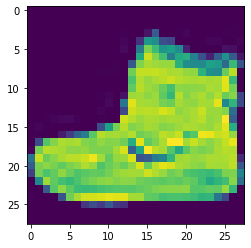

In [57]:
plt.imshow(data)
plt.show()

First, we define a function which allows us to plot the image.

In [58]:
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
def plot_image(image):
    # Reshape the list into a 28x28 array
    image = np.array(image).reshape(28, 28)
    # Plot the image using imshow
    plt.imshow(image, cmap = "Greys_r")
    # Remove the axis labels and ticks
    plt.axis('off')
    # Display the plot
    plt.show()

Below you can see the decoded image. For different colors, change cmap in the function above and run the cell below with 

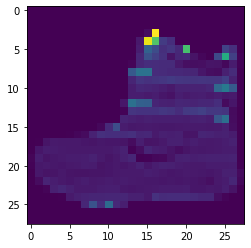

In [59]:
plt.imshow(np.array(image_re).reshape(28, 28))
plt.show()

## Variational Quantum Classifier

reference:   
[1] calculate result from probability, https://github.com/ericardomuten/quantum_image_classifier  
[2] MPS tensor circuit(ideal classifier circuit), https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.043007 , good example from qamp-mentorship https://github.com/qiskit-advocate/qamp-fall-22/issues/28   
[3] Good idea about amplitude circuit, https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.031041

In [60]:
data = fashion_mnist.load_data()

In [61]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [62]:
print('Train Set')
print(X_train.shape)
print(Y_train.shape)


Train Set
(60000, 28, 28)
(60000,)


In [63]:
print('Test Set')
print(X_test.shape)
print(Y_test.shape)



Test Set
(10000, 28, 28)
(10000,)


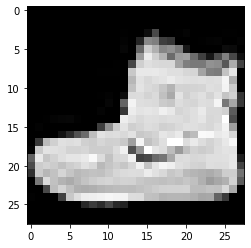

In [64]:
plt.imshow(X_train[0], cmap='gist_gray')
plt.show()

In [65]:
# Filter images and labels with label 0 and 1
filtered_train_idx = (Y_train == 0) | (Y_train == 1)
X_train = X_train[filtered_train_idx]
Y_train = Y_train[filtered_train_idx]

filtered_test_idx = (Y_test == 0) | (Y_test == 1)
X_test = X_test[filtered_test_idx]
Y_test = Y_test[filtered_test_idx]

print("Number of training images:", X_train.shape[0])
print("Number of test images:", X_test.shape[0])

Number of training images: 12000
Number of test images: 2000


In [66]:
x = simulate(encode_shallow(16, X_train[1]))

NameError: name 'encode_shallow' is not defined

In [ ]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler


In [ ]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

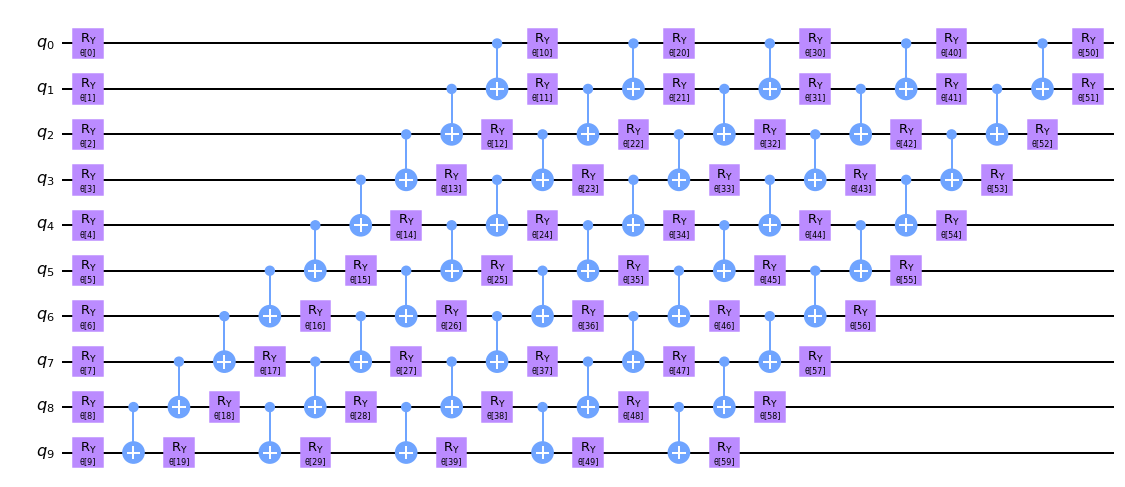

In [ ]:
num_qubits = 10
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

In [ ]:
def interpret(x):
   return x


# QNN Definition
qnn = SamplerQNN(
    sampler=Sampler(),
    circuit=qc,
    input_params=qc.parameters,
    weight_params=circ.parameters,
    interpret=interpret,
    output_shape=2,
)


In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)


In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(simulate(encode_shallow(16, X_train[0:100])), Y_train[0:100])

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(np.array(X_test_list[0:100]), Y_train[0:100])


AttributeError: 'numpy.ndarray' object has no attribute 'name'

In [ ]:
def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    positive=0
    label = ''
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
    
    if isclose(positive, 0, rel_tol=1e-1, abs_tol=0.0):
        label = "T-shirt/Top"
    elif isclose(positive, 1, rel_tol=1e-1, abs_tol=0.0):
        label = "Trousers"
    elif isclose(positive, 2, rel_tol=1e-1, abs_tol=0.0):
        label = "Pullover"
    elif isclose(positive, 3, rel_tol=1e-1, abs_tol=0.0):
        label = "Dress"
    elif isclose(positive, 4, rel_tol=1e-1, abs_tol=0.0):
        label = "Coat"
    elif isclose(positive, 5, rel_tol=1e-1, abs_tol=0.0):
        label = "Sandals"
    elif isclose(positive, 6, rel_tol=1e-1, abs_tol=0.0):
        label = "Shirt"
    elif isclose(positive, 7, rel_tol=1e-1, abs_tol=0.0):
        label = "Sneakers"
    elif isclose(positive, 8, rel_tol=1e-1, abs_tol=0.0):
        label = "Bag"
    elif isclose(positive, 9, rel_tol=1e-1, abs_tol=0.0):
        label = "Angle boots"
        
    return label

In [ ]:
classifier = pickle.load(open("circuit.pickle", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'circuit.pickle'

In [ ]:
classifier = QuantumCircuit.from_qasm_file("iQuHACK/circuit.qasm")

In [ ]:
classify_operator = Operator(ansatz)
hist_vec = [*hist_vector]
hist_vec.extend(np.zeros(240))

print(len(hist_vec))
hist_vec = Statevector(data = hist_vec)
output_statevector = hist_vec.evolve(classify_operator)

1024


In [ ]:
features = []
for i in range(1024):
    features.append(bin(i)[2:].zfill(10))

output_statevector = list(i.real for i in output_statevector)

hist_dictionary = dict(zip(features, output_statevector))

In [ ]:
histogram_to_category(hist_dictionary)

'Sneakers'